Notebook that analyses annotator agreement - still need to tidy up and add some comments to this notebook, or to delete it as I'm not sure we will make use of it.

In [14]:
import os
import pandas as pd
from mtqe.data.loaders import load_ced_test_data, load_ced_data
from mtqe.utils.paths import EVAL_DIR, PREDICTIONS_DIR
from mtqe.utils.plots import create_annotator_cm_plot
from mtqe.utils.language_pairs import LI_LANGUAGE_PAIRS_WMT_21_CED
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

In [15]:
EXPERIMENT_GROUP_NAME = 'train_monolingual_auth_data'
DATA_SPLIT = 'dev'
THRESHOLD_STRATEGY = 'default'
FILE_SUFFIX = 'median_results.csv'
CHART_NAME = 'Monolingual Authentic Data'

In [16]:
eval_files = [os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME, file) for file in os.listdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME)) if file.endswith(FILE_SUFFIX)]
enja_separate = False
if os.path.isdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja')):
    eval_files.extend([os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja', file) for file in os.listdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja')) if file.endswith(FILE_SUFFIX)])
    enja_separate = True
    

In [17]:
dfs = []
for file in eval_files:
    df = pd.read_csv(file)
    dfs.append(df)

df_meta_results = pd.concat(dfs)

In [18]:
df_meta_results = df_meta_results[(df_meta_results['threshold_strategy'] == THRESHOLD_STRATEGY) & (df_meta_results['split'] == DATA_SPLIT)]

In [19]:
df_meta_results.head()

,Unnamed: 0,threshold,MCC,precision,recall,f1,accuracy,threshold_strategy,language_pair,split,seed,model_type,exp_group
1,7,0.5,0.472181,0.593750,0.530726,0.560472,0.851,default,en-cs,dev,42,supervised,train_monolingual_auth_data
7,37,0.5,0.479721,0.530249,0.693023,0.600806,0.802,default,en-de,dev,89,supervised,train_monolingual_auth_data
13,67,0.5,0.373985,0.468085,0.458333,0.463158,0.847,default,en-zh,dev,928,supervised,train_monolingual_auth_data
1,7,0.5,0.338867,0.375000,0.423529,0.397790,0.891,default,en-ja,dev,42,supervised,train_monolingual_auth_data_enja


In [20]:
# Get lists of data to create plot
preds = []
targets = []
indices = []
titles = []

for lp in LI_LANGUAGE_PAIRS_WMT_21_CED:
    seed = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['seed']
    mcc = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['MCC']
    precision = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['precision']
    recall = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['recall']
    titles.append('Language pair:' + lp)# + '\nMCC:' + str(mcc.round(3)) + '\nPrecision:' + str(precision.round(3)) + '\nRecall:' + str(recall.round(3)))
    threshold = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['threshold']
    file_prefix = lp + '_' + DATA_SPLIT + '_' + str(seed)
    if lp == 'en-ja' and enja_separate:
        folder = EXPERIMENT_GROUP_NAME + '_enja'
    else:
        folder = EXPERIMENT_GROUP_NAME
    for file in os.listdir(os.path.join(PREDICTIONS_DIR, 'ced_data', folder)):
        if file.startswith(file_prefix) and file.endswith('.csv'):
            # found predictions
            df_preds = pd.read_csv(os.path.join(PREDICTIONS_DIR, 'ced_data', folder, file))
            scores = df_preds['score'].to_numpy()
            scores = 1 - scores
            binary_scores = scores > threshold
            binary_scores = binary_scores.astype('int')
            df_preds['binary_score'] = binary_scores
            # preds.append(binary_scores)
            preds.append(df_preds)
    if DATA_SPLIT == 'test':
        targets.append(1 - load_ced_test_data(lp)['score'].to_numpy())
    else:
        df = load_ced_data(DATA_SPLIT, lp, incl_annotations=True)
        df['annotations'] = df['annotations'].str.replace('[', '')
        df['annotations'] = df['annotations'].str.replace(']', '')
        df[['annotator_1', 'annotator_2', 'annotator_3']] = df['annotations'].str.split(',', expand=True).astype('int')
        df['total_score']= df['annotator_1'] + df['annotator_2'] + df['annotator_3']
        # targets.append(df['total_score'])
        targets.append(df)
        # targets.append(df['annotations'])
        indices.append(load_ced_data(DATA_SPLIT, lp)['idx'])

In [21]:
preds_targets = []
preds_cleaned = []
targets_cleaned = []

for ind, _ in enumerate(preds):
    df = pd.concat([preds[ind], targets[ind]], axis=1)
    print('shape before:', df.shape)
    df = df[(df['annotator_1'].isin([0,1])) & (df['annotator_2'].isin([0,1])) & (df['annotator_3'].isin([0,1]))]
    print('shape after: ', df.shape)
    preds_targets.append(df)
    preds_cleaned.append(df['binary_score'])
    targets_cleaned.append(df['total_score'])

shape before: (1000, 13)
shape after:  (944, 13)
shape before: (1000, 13)
shape after:  (989, 13)
shape before: (1000, 13)
shape after:  (971, 13)
shape before: (1000, 13)
shape after:  (886, 13)


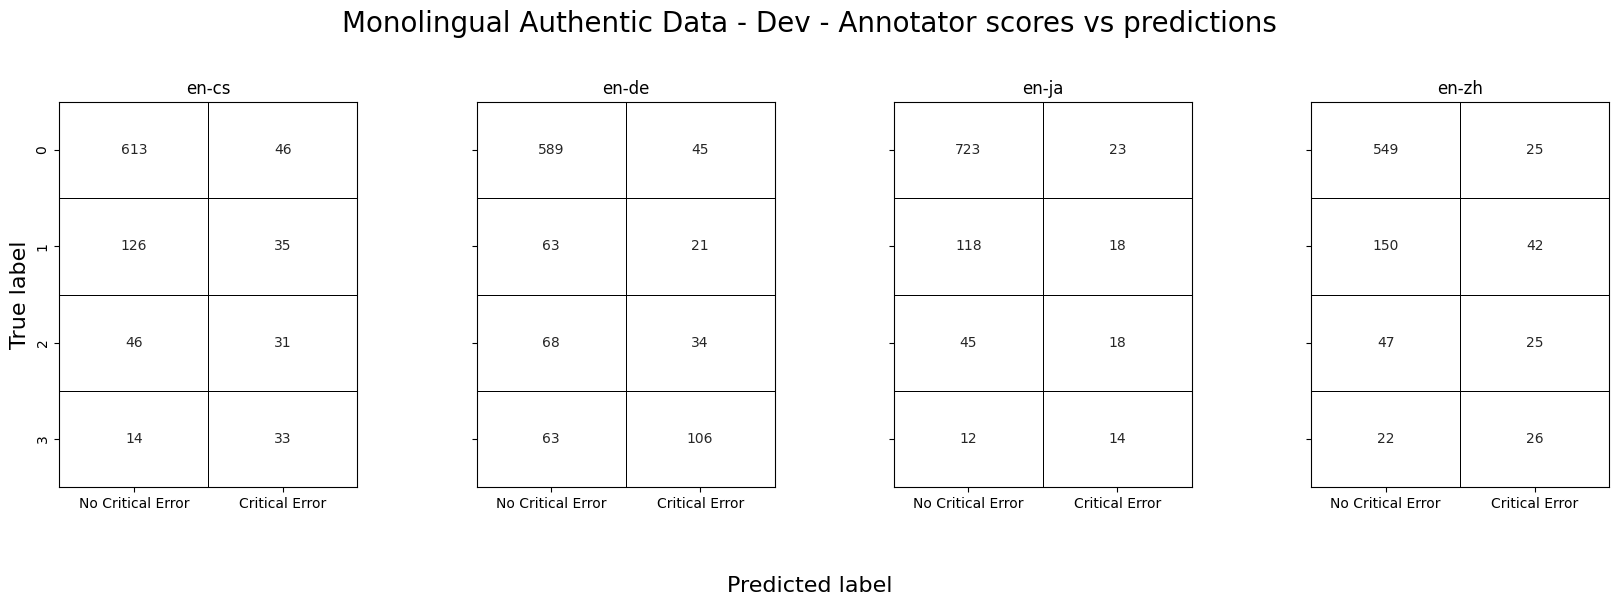

In [22]:
fig = create_annotator_cm_plot(CHART_NAME + ' - Dev - Annotator scores vs predictions', LI_LANGUAGE_PAIRS_WMT_21_CED, preds_cleaned, targets_cleaned)

In [23]:
targets[0]

,idx,src,mt,score,annotations,annotator_1,annotator_2,annotator_3,total_score
0,2601,I think he has a strong relation with second b...,"Myslím , že má silný vztah s druhým dechem pro...",1,"0, 0, 0",0,0,0,0
1,2095,"It is, after all, one of - possibly even the f...","Koneckonců je to jedna z - možná i první , jak...",1,"1, 0, 0",1,0,0,1
2,8392,"Mel, they were already cited. We went to great...","Mel , oni už byli citováni . Dělali jsme velké...",1,"0, 0, 0",0,0,0,0
3,9890,"The IP was doing good, I thought it was adding...","IP se mi dařilo dobře , myslela jsem , že to j...",1,"0, 0, 1",0,0,1,1
4,6079,Knock of the vandlism or i'll report your fuck...,"Zmáčkni ten vandlismus , nebo ti nahlásím tvou...",0,"1, 1, 1",1,1,1,3
...,...,...,...,...,...,...,...,...,...
995,6526,I'll only do that when they're not jerks. Othe...,"Udělám to jen , když nejsou blbci , jinak ne ,...",1,"0, 0, 0",0,0,0,0
996,1405,this is what happens when girls become admins ...,"to se stává , když se dívky stanou správci nej...",1,"0, 0, 0",0,0,0,0
997,5517,This user hates religious people and is out to...,Tento uživatel nenávidí náboženské lidi a je v...,1,"0, 0, 0",0,0,0,0
998,9495,"Basically, homosexuality lowers productivity, ...",Homosexualita v podstatě snižuje produktivitu ...,1,"0, 0, 0",0,0,0,0


In [24]:
preds[0]

,idx,logits,score,binary_score
0,2601,1.617323,0.834426,0
1,2095,2.435457,0.919491,0
2,8392,2.350065,0.912939,0
3,9890,1.656235,0.839732,0
4,6079,-0.516103,0.373764,1
...,...,...,...,...
995,6526,-0.683853,0.335402,1
996,1405,2.374810,0.914886,0
997,5517,1.092871,0.748922,0
998,9495,2.355322,0.913356,0
